In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy

import seaborn as sn
import pandas as pd


PROFS = ['professor', 'physician', 'attorney', 'photographer', 'journalist', 'nurse', 'psychologist', 'teacher',
'dentist', 'surgeon', 'architect', 'painter', 'model', 'poet', 'filmmaker', 'software_engineer',
'accountant', 'composer', 'dietitian', 'comedian', 'chiropractor', 'pastor', 'paralegal', 'yoga_teacher',
'dj', 'interior_designer', 'personal_trainer', 'rapper']

PROF2UNIFIED_PROF = {"associate professor": "professor", "assistant professor": "professor", "software engineer": "software_engineer", "psychotherapist": "psychologist", "orthopedic surgeon": "surgeon", "trial lawyer": "attorney","plastic surgeon": "surgeon",  "trial attorney": "attorney", "senior software engineer": "software_engineer", "interior designer": "interior_designer", "certified public accountant": "accountant", "cpa": "accountant", "neurosurgeon": "surgeon", "yoga teacher": "yoga_teacher", "nutritionist": "dietitian", "personal trainer": "personal_trainer", "certified personal trainer": "personal_trainer", "yoga instructor": "yoga_teacher"}

In [2]:
def load_data(fname = "../data/BIOS.pkl"):
    with open(fname, "rb") as f:
        data = pickle.load(f)
    for i, data_dict in enumerate(data):
        
        prof = data_dict["raw_title"].lower()
        data[i]["raw_title"] = PROF2UNIFIED_PROF[prof] if prof in PROF2UNIFIED_PROF else prof
    
    return data
        
        
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["gender"], entry["raw_title"]
        counter[prof.lower()][gender.lower()] += 1
        
    return counter

def filter_dataset(data, topk = 10):
    
    filtered = []
    counter = count_profs_and_gender(data)
    total_counts = [(prof, counter[prof]["f"] + counter[prof]["m"]) for prof in counter.keys()]
    profs_by_frq = sorted(total_counts, key = lambda x: -x[1])
    topk_profs = [p[0] for p in profs_by_frq[:topk]]
    
    print("Top-k professions: {}".format(topk_profs))
    for d in data:
        
        if d["raw_title"].lower() in topk_profs:
            filtered.append(d)
    
    return filtered
    
def split_train_dev_test(data):
    
    g2i, i2g = {"m": 0, "f": 1}, {1: "f", 0: "m"}
    all_profs = list(set([d["raw_title"] for d in data]))
    all_words = []
    for d in data:
        all_words.extend(d["raw"].split(" "))
    
    all_words = set(all_words)
    all_words.add("<UNK>")
    
    p2i = {p:i for i,p in enumerate(sorted(all_profs))}
    i2p = {i:p for i,p in enumerate(sorted(all_profs))}
    w2i = {w:i for i,w in enumerate(sorted(all_words))}
    i2w = {i:w for i,w in enumerate(sorted(all_words))}
    
    all_data = []
    for entry in tqdm.tqdm(data, total = len(data)):
        gender, prof = entry["gender"].lower(), entry["raw_title"].lower()
        #if prof in PROF2UNITED_PROF: prof = PROF2UNITED_PROF[prof]
        raw, start_index = entry["raw"], entry["start_pos"]
        all_data.append({"g": g2i[gender], "p": p2i[prof], "text": raw, "start": start_index})


    train_dev, test = sklearn.model_selection.train_test_split(all_data, test_size = 0.2, random_state = 0)
    train, dev = sklearn.model_selection.train_test_split(train_dev, test_size = 0.3, random_state = 0)
    print("Train size: {}; Dev size: {}; Test size: {}".format(len(train), len(dev), len(test)))
    return (train, dev, test), (g2i, i2g, p2i, i2p, w2i, i2w)


In [3]:
data = load_data()
data = filter_dataset(data, topk = 60)
counter = count_profs_and_gender(data)
(train, dev, test), (g2i, i2g, p2i, i2p, w2i, i2w) = split_train_dev_test(data)

Top-k professions: ['professor', 'physician', 'attorney', 'photographer', 'journalist', 'nurse', 'psychologist', 'teacher', 'surgeon', 'architect', 'dentist', 'painter', 'model', 'poet', 'filmmaker', 'software_engineer', 'composer', 'accountant', 'dietitian', 'comedian', 'pastor', 'chiropractor', 'yoga_teacher', 'paralegal', 'interior_designer', 'dj', 'rapper', 'personal_trainer']


100%|██████████| 256682/256682 [00:00<00:00, 882593.32it/s]


Train size: 143741; Dev size: 61604; Test size: 51337


In [4]:
f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.4601530298189978
{'professor': 0.44646425025434844, 'accountant': 0.36577571179546775, 'journalist': 0.49154108615297126, 'architect': 0.2259514534012586, 'photographer': 0.34264979307863014, 'psychologist': 0.6136403279260422, 'teacher': 0.5910666153253754, 'nurse': 0.9093374004406033, 'attorney': 0.3740997100364793, 'software_engineer': 0.14638906961613532, 'painter': 0.4558157842944302, 'physician': 0.5387556626906612, 'chiropractor': 0.2734006734006734, 'personal_trainer': 0.4574944071588367, 'surgeon': 0.13943446162418163, 'filmmaker': 0.33133304757822546, 'dietitian': 0.934312525499796, 'dentist': 0.33087903831705484, 'dj': 0.1476293103448276, 'model': 0.8319000819000819, 'composer': 0.15396419437340153, 'poet': 0.4894098293234629, 'comedian': 0.2055929570170896, 'yoga_teacher': 0.8435438265786993, 'interior_designer': 0.8100320170757738, 'pastor': 0.23668639053254437, 'rapper': 0.08657047724750278, 'paralegal': 0.8536345776031434}


In [5]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [6]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_gendered.glove.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def get_embeddings_based_dataset(data: List[dict], word2vec_model):
    
    X, Y = [], []
    unk, total = 0., 0.
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        #print(text)
        #print("----------")
        #print(" ".join(words))
        #print("=====================")
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model['unk'] for w in words], axis = 0)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        unk += len([w for w in words if w not in word2vec_model])
    
    print("% unknown: {}".format(unk/total))
    return X,Y

def get_BOW_based_dataset(data: List[dict], w2i):
    
    vectorizer = DictVectorizer(sparse = True)
    X, Y = [], []
    unk, total = 0., 0.
    data_dicts = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        entry_dict = {w:w2i[w] if w in w2i else w2i["<UNK>"] for w in words}
        data_dicts.append(entry_dict)
        Y.append(y)
        
        total += len(words)
        unk += len([w for w in words if w not in w2i])
    
    print("% unknown: {}".format(unk/total))
    X = vectorizer.fit_transform(data_dicts)
    return X,Y
    
def get_bert_based_dataset(data: List[dict]):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = BertModel.from_pretrained('bert-base-cased').cuda()
    model.eval()
    
    X, Y = [], []
    print("here")
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()            
        tokenized_text = tokenizer.tokenize(sentence_str)    
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])
        with torch.no_grad():
              outputs = model(tokens_tensor)
              print(outputs.shape)
              return
            

In [7]:
#word2vec, vecs, words = load_word_vectors("../data/embeddings/wiki-news-300d-1M-subword.vec") #load_word2vec()
word2vec, vecs, words = load_word_vectors("../data/embeddings/wiki-news-300d-1M-subword.vec")
#word2vec.init_sims(replace = True)
#X_train, Y_train = get_BOW_based_dataset(train, w2i)
#X_dev, Y_dev = get_BOW_based_dataset(dev, w2i) 


In [8]:
X_train, Y_train = get_embeddings_based_dataset(train, word2vec)
X_dev, Y_dev =  get_embeddings_based_dataset(dev, word2vec)

#X_train, Y_train = get_bert_based_dataset(train)

  1%|          | 584/61604 [00:00<00:10, 5833.45it/s]

% unknown: 0.1063134677847156


100%|██████████| 61604/61604 [00:10<00:00, 5945.34it/s]

% unknown: 0.10630624264919851


In [9]:
#clf = LinearSVC(verbose = 10) #LogisticRegression()
clf = LogisticRegression(warm_start = True,
                         solver = "sag", multi_class = 'multinomial',
                         verbose = 0, n_jobs = 32)
clf.fit(X_train, Y_train)
print(clf.score(X_dev, Y_dev))
clf_original = copy.deepcopy(clf)

0.7439289656515811


#### Confusion Matrix

In [12]:
y_hat = clf.predict(X_dev)
cm = sklearn.metrics.confusion_matrix(Y_dev,y_hat)
labels = [i2p[i] for i in range(len(i2p))]

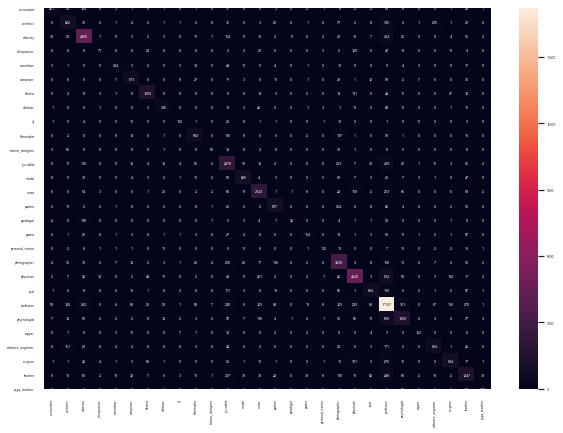

In [13]:


df_cm = pd.DataFrame(cm, index = labels, columns = labels)
#plt.figure(figsize = (10,7))
sn.set(font_scale=0.3)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig("confusion.png", dpi = 600)
plt.show()

### perform debiasing

In [14]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, dim=300):

    is_autoregressive = True
    siamese = False
    reg = "l2"
    min_acc = 0.
    noise = False
    random_subset = False
    regression = False

    P = debias.get_debiasing_projection(None, num_clfs, dim, is_autoregressive, min_acc, X_train, Y_train, X_dev, Y_dev,
                                              noise = noise, random_subset = random_subset,
                                              regression = regression, siamese = siamese, siamese_dim = 1)

    return P



num_clfs = 35
Y_dev_gender = np.array([d["g"] for d in dev])
Y_train_gender = np.array([d["g"] for d in train])
X_train = np.array(X_train)
X_dev = np.array(X_dev)
P = get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, dim = 300)

Iteration 0, Accuracy: 0.9957145639893513
Iteration 1, Accuracy: 0.9891240828517629
Iteration 2, Accuracy: 0.9639146808648789
Iteration 3, Accuracy: 0.9179761054476983
Iteration 4, Accuracy: 0.8663885461982989
Iteration 5, Accuracy: 0.8166352834231544
Iteration 6, Accuracy: 0.7722875137978054
Iteration 7, Accuracy: 0.7334426335952211
Iteration 8, Accuracy: 0.7061716771638206
Iteration 9, Accuracy: 0.6843711447308616
Iteration 10, Accuracy: 0.6642750470748653
Iteration 11, Accuracy: 0.6482858255957406
Iteration 12, Accuracy: 0.6479611713525095
Iteration 13, Accuracy: 0.6277027465748978
Iteration 14, Accuracy: 0.6178981884293228
Iteration 15, Accuracy: 0.6018765015258749
Iteration 16, Accuracy: 0.5891662879033829
Iteration 17, Accuracy: 0.5797675475618467
Iteration 18, Accuracy: 0.571959613012142
Iteration 19, Accuracy: 0.5720732419972729
Iteration 20, Accuracy: 0.5636159989611064
Iteration 21, Accuracy: 0.5634536718394909
Iteration 22, Accuracy: 0.5604993182260892
Iteration 23, Accuracy

#### test model without finetuning

In [45]:
print(clf.score(X_dev.dot(P), Y_dev))

0.6951983637426141


### Perform finetuning

In [46]:
clf.fit(X_train.dot(P), Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=32, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=True)

#### test again

In [47]:
print(clf.score(X_dev.dot(P), Y_dev))

0.7360398675410688


In [25]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = good_m / prof_total_m
        tpr_f = good_f / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(tpr_m/tpr_f)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            scores[i2p[y]][g] += 1 # count false positives for y
        
        prof_count_total[i2p[y]][g] += 1 # count "not y"
    
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        fpr_m = good_m / prof_total_m
        fpr_f = good_f / prof_total_f
        
        fprs[profession]["m"] = fpr_m
        fprs[profession]["f"] = fpr_f
        fprs_ratio.append(fpr_m/fpr_f)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 4, color = "red")
    plt.savefig("{}_vs_bias_{}".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

Correlation: -0.8722481712689054; p-value: 1.4735999358303977e-09


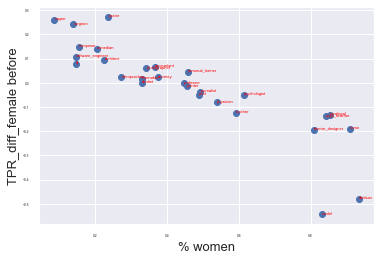

Correlation: -0.3523432128391113; p-value: 0.06593012035375916


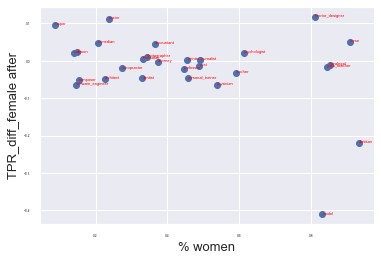

TPR diff ratio before: 1.0127905178538892; after: 1.0299463597750822
Correlation: 0.8722481712689051; p-value: 1.473599935830445e-09


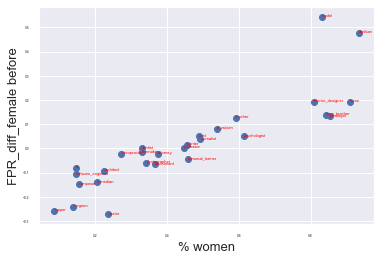

Correlation: 0.3523432128391113; p-value: 0.06593012035375916


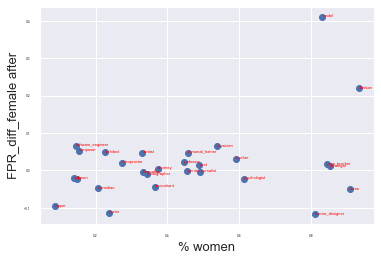

TPR diff ratio before: 1.142071962746729; after: 1.086480513960354


In [27]:
y_pred_before = clf_original.predict(X_dev)
dev_gender = [i2g[d["g"]] for d in dev]
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, Y_dev, p2i, i2p, dev_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)


y_pred_after = clf.predict(X_dev.dot(P))
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, Y_dev, p2i, i2p, dev_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))


fprs_before, fprs_change_before, mean_ratio_before = get_FPR(y_pred_before, Y_dev, p2i, i2p, dev_gender)
similarity_vs_tpr(fprs_change_before, word2vec, "before", "FPR", prof2fem)


fprs, fprs_change_after, mean_ratio_after = get_FPR(y_pred_after, Y_dev, p2i, i2p, dev_gender)
similarity_vs_tpr(fprs_change_after, word2vec, "after", "FPR", prof2fem)

print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))

In [37]:
prof2fem["model"]

0.8319000819000819

In [38]:
counter

defaultdict(collections.Counter,
            {'professor': Counter({'f': 36423, 'm': 45158}),
             'accountant': Counter({'m': 2183, 'f': 1259}),
             'journalist': Counter({'f': 6915, 'm': 7153}),
             'architect': Counter({'m': 5166, 'f': 1508}),
             'photographer': Counter({'m': 10960, 'f': 5713}),
             'psychologist': Counter({'m': 4430, 'f': 7036}),
             'teacher': Counter({'f': 6140, 'm': 4248}),
             'nurse': Counter({'f': 10732, 'm': 1070}),
             'attorney': Counter({'f': 7999, 'm': 13383}),
             'software_engineer': Counter({'m': 3936, 'f': 675}),
             'painter': Counter({'f': 2316, 'm': 2765}),
             'physician': Counter({'m': 11098, 'f': 12963}),
             'chiropractor': Counter({'m': 1079, 'f': 406}),
             'personal_trainer': Counter({'m': 485, 'f': 409}),
             'surgeon': Counter({'m': 6178, 'f': 1001}),
             'filmmaker': Counter({'m': 3120, 'f': 1546}),
     

In [75]:
idx = np.random.rand(X_dev.shape[0]) < 0.15
x_dev_labels = np.array([i2p[y] for i,y in enumerate(Y_dev)])
save_vecs_and_words(X_dev[idx], x_dev_labels[idx])

In [65]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.1)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
            
  plt.show()
  return vecs_2d

{'accountant': 0,
 'architect': 1,
 'attorney': 2,
 'chiropractor': 3,
 'comedian': 4,
 'composer': 5,
 'dentist': 6,
 'dietitian': 7,
 'dj': 8,
 'filmmaker': 9,
 'interior_designer': 10,
 'journalist': 11,
 'model': 12,
 'nurse': 13,
 'painter': 14,
 'paralegal': 15,
 'pastor': 16,
 'personal_trainer': 17,
 'photographer': 18,
 'physician': 19,
 'poet': 20,
 'professor': 21,
 'psychologist': 22,
 'rapper': 23,
 'software_engineer': 24,
 'surgeon': 25,
 'teacher': 26,
 'yoga_teacher': 27}